In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rasterio as rio
import s3fs

# Months to retrieve and subset
months = ['201005', '201006']

# File name of elevation data for UBRB boundary
elev_fname = '../data/ubrb_dem_30m.tif'

# S3FS path for NLDAS-3 data
nldas3_s3fs_url = 'nasa-waterinsight/NLDAS3/forcing/hourly/'

# Output file parameters
output_dir = '../data/ubrb_nldas3/'
output_filebase = 'nldas3_UBRB_subset_'
output_fileext = '.nc'

In [2]:
elev_data = rio.open(elev_fname)

coords_UBRB = [
    elev_data.bounds.left,
    elev_data.bounds.bottom,
    elev_data.bounds.right,
    elev_data.bounds.top
]

In [3]:
s3 = s3fs.S3FileSystem(anon=True)

In [4]:
remote_files = []

for month in months:
    
    files = s3.ls(nldas3_s3fs_url + month + '/')
    remote_files.extend(files)

In [15]:
for remote_file in remote_files[-6:]:

    # Open remote file
    print('Opening remote file: '+remote_file)
    fileset = s3.open(remote_file)
    
    # Load dataset with xarray
    nldas3_ds = xr.open_dataset(fileset, engine='h5netcdf')

    # Copy and assign CRS for clipping and clip to UBRB bounds
    print('Clipping to UBRB bounds...')    
    nldas3_ss_ds = nldas3_ds.copy(deep=True)
    nldas3_ss_ds = nldas3_ss_ds.rio.write_crs("EPSG:4326", inplace=True)
    nldas3_ss_ds = nldas3_ss_ds.rio.clip_box(*coords_UBRB)

    # Construct output filename and save subsetted data
    output_filename = output_dir+output_filebase+remote_file[-20:-12]+output_fileext
    print('Writing output file: '+output_filename)
    nldas3_ss_ds.to_netcdf(output_filename)
    
    # Print percent complete
    pct_complete = (remote_files.index(remote_file)+1)/len(remote_files)*100
    print(f'Completed: {pct_complete:.1f}%\n')
    
    

Opening remote file: nasa-waterinsight/NLDAS3/forcing/hourly/201006/NLDAS_FOR0010_H.A20100625.030.beta.nc
Clipping to UBRB bounds...
Writing output file: ../data/ubrb_nldas3/nldas3_UBRB_subset_20100625.nc
Completed: 66.7%

Opening remote file: nasa-waterinsight/NLDAS3/forcing/hourly/201006/NLDAS_FOR0010_H.A20100626.030.beta.nc
Clipping to UBRB bounds...
Writing output file: ../data/ubrb_nldas3/nldas3_UBRB_subset_20100626.nc
Completed: 73.3%

Opening remote file: nasa-waterinsight/NLDAS3/forcing/hourly/201006/NLDAS_FOR0010_H.A20100627.030.beta.nc
Clipping to UBRB bounds...
Writing output file: ../data/ubrb_nldas3/nldas3_UBRB_subset_20100627.nc
Completed: 80.0%

Opening remote file: nasa-waterinsight/NLDAS3/forcing/hourly/201006/NLDAS_FOR0010_H.A20100628.030.beta.nc
Clipping to UBRB bounds...
Writing output file: ../data/ubrb_nldas3/nldas3_UBRB_subset_20100628.nc
Completed: 86.7%

Opening remote file: nasa-waterinsight/NLDAS3/forcing/hourly/201006/NLDAS_FOR0010_H.A20100629.030.beta.nc
Cl

In [16]:
nldas3_ubrb_ds = xr.open_mfdataset(output_dir+output_filebase+'*'+output_fileext, combine='by_coords')
nldas3_ubrb_ds

<xarray.Dataset> Size: 610MB
Dimensions:      (time: 1464, lat: 88, lon: 148)
Coordinates:
  * lon          (lon) float32 592B -116.1 -116.1 -116.1 ... -114.6 -114.6
  * lat          (lat) float32 352B 43.22 43.24 43.24 43.26 ... 44.08 44.08 44.1
  * time         (time) datetime64[ns] 12kB 2010-05-01 ... 2010-06-30T23:00:00
Data variables:
    spatial_ref  (time) int64 12kB 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    Tair         (time, lat, lon) float32 76MB dask.array<chunksize=(24, 88, 148), meta=np.ndarray>
    Qair         (time, lat, lon) float32 76MB dask.array<chunksize=(24, 88, 148), meta=np.ndarray>
    PSurf        (time, lat, lon) float32 76MB dask.array<chunksize=(24, 88, 148), meta=np.ndarray>
    LWdown       (time, lat, lon) float32 76MB dask.array<chunksize=(24, 88, 148), meta=np.ndarray>
    SWdown       (time, lat, lon) float32 76MB dask.array<chunksize=(24, 88, 148), meta=np.ndarray>
    Wind_N       (time, lat, lon) float32 76MB dask.array<chunksize=(24, 88, 148), meta=np.ndarray>
    Wind_E       (time, lat, lon) float32 76MB dask.array<chunksize=(24, 88, 148), meta=np.ndarray>
    Rainf        (time, lat, lon) float32 76MB dask.array<chunksize=(24, 88, 148), meta=np.ndarray>
Attributes: (12/17)
    missing_value:          -9999.0
    time_definition:        hourly
    shortname:              NLDAS_FOR0010_H_3.0
    title:                  NLDAS Forcing Data L4 Hourly 0.01 x 0.01 degree V...
    version:                3.0 beta
    institution:            NASA GSFC
    ...                     ...
    websites:               https://ldas.gsfc.nasa.gov/nldas/v3/ ; https://li...
    MAP_PROJECTION:         EQUIDISTANT CYLINDRICAL
    SOUTH_WEST_CORNER_LAT:  7.005
    SOUTH_WEST_CORNER_LON:  -168.995
    DX:                     0.01
    DY:                     0.01

In [17]:
(30+31)*24

1464

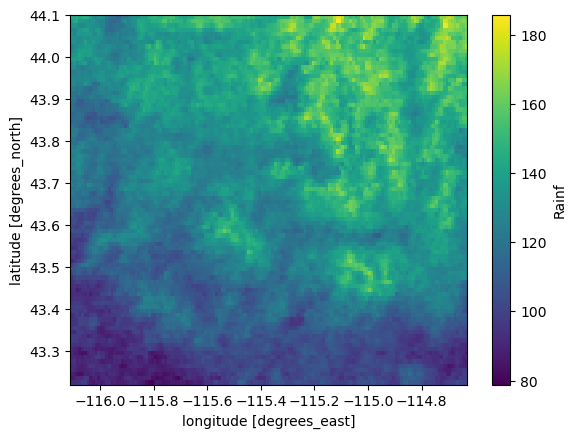

In [20]:
nldas3_ubrb_ds['Rainf'].sum(dim='time').plot()